In [1]:
import re
import pandas as pd
import preprocess.pre as pre
df = pd.read_csv('../data/nlp.csv')
df.drop(['PostTypeId', 'ParentId', 'OwnerUserId', 'OwnerDisplayName','LastEditorUserId', 'LastEditorDisplayName', 'AcceptedAnswerId', 'Score',
       'ViewCount', 'AnswerCount', 'CommentCount', 'FavoriteCount'],axis=1,inplace=True)
df['nltk'] = False
df['spacy'] = False
df['gensim'] = False
df['stanford-nlp'] = False
df['scikit-learn'] = False

def isnltk(str):
    a = re.search(r'\bnltk\b', str)
    if a is None:
        return False
    else:
        return True
def isspacy(str):
    a = re.search(r'\bspacy\b', str)
    if a is None:
        return False
    else:
        return True
def isgensim(str):
    a = re.search(r'\bgensim\b', str)
    if a is None:
        return False
    else:
        return True
def isstanford_nlp(str):
    a = re.search(r'\b(stanford-nlp|stanford nlp)\b', str)
    if a is None:
        return False
    else:
        return True
def issklearn(str):
    a = re.search(r'\b(scikit-learn|scikit learn|sklearn)\b', str)
    if a is None:
        return False
    else:
        return True

In [2]:
for index, row in df.iterrows():
    title = str(row['Title'])
    tags = str(row['Tags'])
    body = str(row['Body'])
    title = pre.processbody(title)
    # print(title)
    body = pre.processbody(body)
    tags = pre.preprocesstag(tags)
    df.at[index, 'nltk'] = isnltk(title)|isnltk(body)|isnltk(tags)
    df.at[index, 'spacy'] = isspacy(title)|isspacy(body)|isspacy(tags)
    df.at[index, 'gensim'] = isgensim(title)|isgensim(body)|isgensim(tags)
    df.at[index, 'stanford-nlp'] = isstanford_nlp(title)|isstanford_nlp(body)|isstanford_nlp(tags)
    df.at[index, 'scikit-learn'] = issklearn(title)|issklearn(body)|issklearn(tags)

nltk = df[df['nltk']==True]
spacy = df[df['spacy']==True]
gensim = df[df['gensim']==True]
stanfordnlp = df[df['stanford-nlp']==True]
sklearn = df[df['scikit-learn']==True]

# nltk.to_csv('../analysislib/nlp/nltk.csv')
# spacy.to_csv('../analysislib/nlp/spacy.csv')
# gensim.to_csv('../analysislib/nlp/gensim.csv')
# stanfordnlp.to_csv('../analysislib/nlp/stanfordnlp.csv')
# sklearn.to_csv('../analysislib/nlp/sklearn.csv')



In [3]:
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
df = df.set_index('CreationDate')
df = df.resample('Y').count().to_period('Y')
df


,Id,DeletionDate,Body,LastEditDate,LastActivityDate,Title,Tags,ClosedDate,CommunityOwnedDate,ContentLicense,nltk,spacy,gensim,stanford-nlp,scikit-learn
CreationDate,,,,,,,,,,,,,,,
2012,1067,0,1067,672,1067,1067,1067,79,1,1067,1067,1067,1067,1067,1067
2013,1484,0,1484,861,1484,1484,1484,102,1,1484,1484,1484,1484,1484,1484
2014,2106,0,2106,1141,2106,2106,2106,96,0,2106,2106,2106,2106,2106,2106
2015,2832,0,2832,1608,2832,2832,2832,100,0,2832,2832,2832,2832,2832,2832
2016,3367,0,3367,1751,3367,3367,3367,137,0,3367,3367,3367,3367,3367,3367
2017,4338,0,4338,2139,4338,4338,4338,144,0,4338,4338,4338,4338,4338,4338
2018,4362,0,4362,2330,4362,4362,4362,142,0,4362,4362,4362,4362,4362,4362
2019,4816,0,4816,2425,4816,4816,4816,98,0,4816,4816,4816,4816,4816,4816
2020,5045,0,5045,2126,5045,5045,5045,113,0,5045,5045,5045,5045,5045,5045


In [4]:
nltk['CreationDate'] = pd.to_datetime(nltk['CreationDate'])
nltk = nltk.set_index('CreationDate')
nltk = nltk.resample('Y').count().to_period('Y')
nltk


<ipython-input-4-df146b6cc97e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nltk['CreationDate'] = pd.to_datetime(nltk['CreationDate'])


,Id,DeletionDate,Body,LastEditDate,LastActivityDate,Title,Tags,ClosedDate,CommunityOwnedDate,ContentLicense,nltk,spacy,gensim,stanford-nlp,scikit-learn
CreationDate,,,,,,,,,,,,,,,
2012,254,0,254,161,254,254,254,15,0,254,254,254,254,254,254
2013,439,0,439,249,439,439,439,29,0,439,439,439,439,439,439
2014,588,0,588,325,588,588,588,33,0,588,588,588,588,588,588
2015,743,0,743,467,743,743,743,28,0,743,743,743,743,743,743
2016,915,0,915,504,915,915,915,69,0,915,915,915,915,915,915
2017,960,0,960,516,960,960,960,63,0,960,960,960,960,960,960
2018,920,0,920,527,920,920,920,55,0,920,920,920,920,920,920
2019,769,0,769,395,769,769,769,28,0,769,769,769,769,769,769
2020,707,0,707,343,707,707,707,24,0,707,707,707,707,707,707


In [5]:
spacy['CreationDate'] = pd.to_datetime(spacy['CreationDate'])
spacy = spacy.set_index('CreationDate')
spacy = spacy.resample('Y').count().to_period('Y')
spacy


<ipython-input-5-58ecc7fab468>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spacy['CreationDate'] = pd.to_datetime(spacy['CreationDate'])


,Id,DeletionDate,Body,LastEditDate,LastActivityDate,Title,Tags,ClosedDate,CommunityOwnedDate,ContentLicense,nltk,spacy,gensim,stanford-nlp,scikit-learn
CreationDate,,,,,,,,,,,,,,,
2015,3,0,3,1,3,3,3,0,0,3,3,3,3,3,3
2016,73,0,73,43,73,73,73,1,0,73,73,73,73,73,73
2017,251,0,251,114,251,251,251,3,0,251,251,251,251,251,251
2018,496,0,496,234,496,496,496,10,0,496,496,496,496,496,496
2019,779,0,779,355,779,779,779,12,0,779,779,779,779,779,779
2020,718,0,718,280,718,718,718,10,0,718,718,718,718,718,718


In [6]:
gensim['CreationDate'] = pd.to_datetime(gensim['CreationDate'])
gensim = gensim.set_index('CreationDate')
gensim = gensim.resample('Y').count().to_period('Y')
gensim


<ipython-input-6-623061218812>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gensim['CreationDate'] = pd.to_datetime(gensim['CreationDate'])


,Id,DeletionDate,Body,LastEditDate,LastActivityDate,Title,Tags,ClosedDate,CommunityOwnedDate,ContentLicense,nltk,spacy,gensim,stanford-nlp,scikit-learn
CreationDate,,,,,,,,,,,,,,,
2012,8,0,8,5,8,8,8,0,0,8,8,8,8,8,8
2013,31,0,31,17,31,31,31,1,0,31,31,31,31,31,31
2014,71,0,71,32,71,71,71,0,0,71,71,71,71,71,71
2015,114,0,114,53,114,114,114,2,0,114,114,114,114,114,114
2016,218,0,218,103,218,218,218,0,0,218,218,218,218,218,218
2017,418,0,418,180,418,418,418,5,0,418,418,418,418,418,418
2018,466,0,466,236,466,466,466,3,0,466,466,466,466,466,466
2019,450,0,450,214,450,450,450,1,0,450,450,450,450,450,450
2020,328,0,328,134,328,328,328,5,0,328,328,328,328,328,328


In [7]:
stanfordnlp['CreationDate'] = pd.to_datetime(stanfordnlp['CreationDate'])
stanfordnlp = stanfordnlp.set_index('CreationDate')
stanfordnlp = stanfordnlp.resample('Y').count().to_period('Y')
stanfordnlp


<ipython-input-7-aab31358cde3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stanfordnlp['CreationDate'] = pd.to_datetime(stanfordnlp['CreationDate'])


,Id,DeletionDate,Body,LastEditDate,LastActivityDate,Title,Tags,ClosedDate,CommunityOwnedDate,ContentLicense,nltk,spacy,gensim,stanford-nlp,scikit-learn
CreationDate,,,,,,,,,,,,,,,
2012,110,0,110,71,110,110,110,9,0,110,110,110,110,110,110
2013,182,0,182,116,182,182,182,10,0,182,182,182,182,182,182
2014,272,0,272,147,272,272,272,10,0,272,272,272,272,272,272
2015,645,0,645,313,645,645,645,12,0,645,645,645,645,645,645
2016,555,0,555,270,555,555,555,13,0,555,555,555,555,555,555
2017,537,0,537,234,537,537,537,10,0,537,537,537,537,537,537
2018,353,0,353,153,353,353,353,8,0,353,353,353,353,353,353
2019,218,0,218,102,218,218,218,2,0,218,218,218,218,218,218
2020,196,0,196,82,196,196,196,1,0,196,196,196,196,196,196


In [8]:
sklearn['CreationDate'] = pd.to_datetime(sklearn['CreationDate'])
sklearn = sklearn.set_index('CreationDate')
sklearn = sklearn.resample('Y').count().to_period('Y')
sklearn


<ipython-input-8-0e9f67d73222>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sklearn['CreationDate'] = pd.to_datetime(sklearn['CreationDate'])


,Id,DeletionDate,Body,LastEditDate,LastActivityDate,Title,Tags,ClosedDate,CommunityOwnedDate,ContentLicense,nltk,spacy,gensim,stanford-nlp,scikit-learn
CreationDate,,,,,,,,,,,,,,,
2012,12,0,12,7,12,12,12,0,0,12,12,12,12,12,12
2013,43,0,43,25,43,43,43,0,0,43,43,43,43,43,43
2014,111,0,111,68,111,111,111,1,0,111,111,111,111,111,111
2015,158,0,158,92,158,158,158,0,0,158,158,158,158,158,158
2016,231,0,231,124,231,231,231,10,0,231,231,231,231,231,231
2017,288,0,288,160,288,288,288,6,0,288,288,288,288,288,288
2018,261,0,261,155,261,261,261,8,0,261,261,261,261,261,261
2019,295,0,295,174,295,295,295,2,0,295,295,295,295,295,295
2020,232,0,232,112,232,232,232,8,0,232,232,232,232,232,232


In [4]:
cnt = 0
for index, row in df.iterrows():
    if(row['nltk']==True or row['spacy']==True or row['gensim']==True or row['stanford-nlp']==True or row['scikit-learn']==True):
        cnt += 1

print(len(df))
print(cnt)


29417
14270


,cnt,percentage
gensim,2301,7.82
ntlk,6860,23.32
sklearn,2098,7.13
spacy,2377,8.08
stanford-nlp,3097,10.53


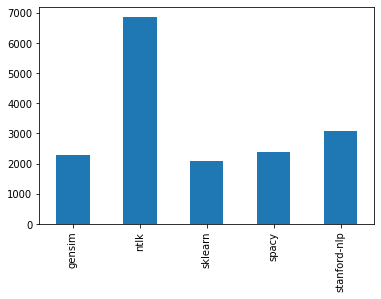

In [21]:
from pandas import DataFrame
libcount = df[['Id', 'CreationDate', 'nltk', 'spacy', 'gensim', 'stanford-nlp', 'scikit-learn']]
data = {'cnt':{'ntlk':len(nltk), 'spacy':len(spacy), 'gensim':len(gensim),
               'stanford-nlp':len(stanfordnlp), 'sklearn':len(sklearn)}}
data = DataFrame(data)
import matplotlib.pyplot as plt
data['percentage'] = 0.0
sum = len(df)
for index, row in data.iterrows():
    data.at[index, 'percentage'] = round(row['cnt']/sum,4)*100

data['cnt'].plot.bar()
# plt.show()
plt.savefig('../picture/nlplib-cnt.png')
data


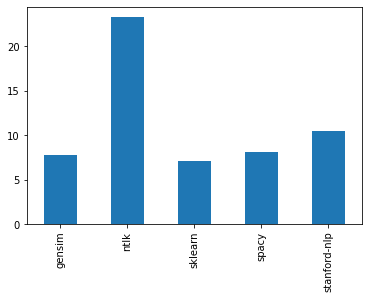

In [23]:
data['percentage'].plot.bar()
# plt.show()
plt.savefig('../picture/nlplib-per.png')


<ipython-input-24-ecaf5d389b28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nltk['CreationDate'] = pd.to_datetime(nltk['CreationDate'])
<ipython-input-24-ecaf5d389b28>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spacy['CreationDate'] = pd.to_datetime(spacy['CreationDate'])
<ipython-input-24-ecaf5d389b28>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

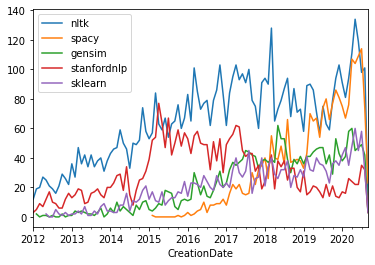

In [24]:
nltk = nltk[['Id','CreationDate']]
nltk['CreationDate'] = pd.to_datetime(nltk['CreationDate'])
nltk = nltk.set_index('CreationDate')
nltk = nltk.resample('M').count().to_period('M')
nltk.rename(columns={'Id':'nltk'},inplace = True)

spacy = spacy[['Id','CreationDate']]
spacy['CreationDate'] = pd.to_datetime(spacy['CreationDate'])
spacy = spacy.set_index('CreationDate')
spacy = spacy.resample('M').count().to_period('M')
spacy.rename(columns={'Id':'spacy'},inplace = True)

gensim = gensim[['Id','CreationDate']]
gensim['CreationDate'] = pd.to_datetime(gensim['CreationDate'])
gensim = gensim.set_index('CreationDate')
gensim = gensim.resample('M').count().to_period('M')
gensim.rename(columns={'Id':'gensim'},inplace = True)

stanfordnlp = stanfordnlp[['Id','CreationDate']]
stanfordnlp['CreationDate'] = pd.to_datetime(stanfordnlp['CreationDate'])
stanfordnlp = stanfordnlp.set_index('CreationDate')
stanfordnlp = stanfordnlp.resample('M').count().to_period('M')
stanfordnlp.rename(columns={'Id':'stanfordnlp'},inplace = True)

sklearn = sklearn[['Id','CreationDate']]
sklearn['CreationDate'] = pd.to_datetime(sklearn['CreationDate'])
sklearn = sklearn.set_index('CreationDate')
sklearn = sklearn.resample('M').count().to_period('M')
sklearn.rename(columns={'Id':'sklearn'},inplace = True)

import matplotlib.pyplot as plt
nlplib = pd.concat([nltk, spacy, gensim, stanfordnlp, sklearn],axis=1)
nlplib.plot()
plt.savefig('../picture/nlplib.png')

In [3]:
import pandas as pd
import preprocess.pre as pre
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
# Remove rare and common tokens.
from gensim.corpora import Dictionary
# Train LDA model.
from gensim.models import LdaModel
from pprint import pprint
import numpy as np
import logging
from gensim.models import CoherenceModel
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [4]:
df = pd.read_csv('../analysislib/nlp/gensim.csv')
docs = []
for index, row in df.iterrows():
    body = pre.preprocess(row['Body'])
    docs.append(body)
print(len(docs))
print(docs[0][:50])

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.save('../analysislib/nlp/gensim.dict')
# dictionary = Dictionary.load('../data/nlp.dict')

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
np.save('../analysislib/nlp/gensim.npy',np.array(corpus))
# corpus = np.load('../data/nlp_corpus.npy').tolist()
print('Number of unique tokens: %d' % len(dictionary))
# print('Number of documents: %d' % len(corpus))

2020-10-30 20:54:04,937 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-10-30 20:54:05,167 : INFO : built Dictionary(13927 unique tokens: ['array', 'computer', 'consume', 'convert', 'corpus']...) from 2301 documents (total 355651 corpus positions)
2020-10-30 20:54:05,168 : INFO : saving Dictionary object under ../analysislib/nlp/gensim.dict, separately None
2020-10-30 20:54:05,173 : INFO : saved ../analysislib/nlp/gensim.dict
<ipython-input-4-c86f6abaf757>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.save('../analysislib/nlp/gensim.npy',np.array(corpus))


2301
p x csr matrix obtained using scikit tfidf vectori
Number of unique tokens: 13927


In [7]:
best_coherence = -100
best_num_topics = 0
coherences = []
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # # Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
for i in range(5,15):

    num_topics = i
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )

    top_topics = model.top_topics(corpus)  # , num_words=20)
    coherence_model_lda = CoherenceModel(model=model, texts=docs, corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    coherences.append(coherence_lda)
    if coherence_lda > best_coherence:
        best_num_topics = i
        best_coherence = coherence_lda
        # model.save('../model/nlp_10/nlp_10.model')
    model.print_topics(num_topics=i, num_words=15)

print("best coherence: "+str(best_coherence))
print("best topic nums: "+str(best_num_topics))
print(coherences)

num_topics = best_num_topics
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)
top_topics = model.top_topics(corpus)  # , num_words=20)
coherence_model_lda = CoherenceModel(model=model, texts=docs, corpus=corpus, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
model.save('../model/nlp_gensim/nlp_gensim.model')
model.print_topics(num_topics=best_num_topics, num_words=15)
print(coherence_lda)

2020-10-30 21:11:18,472 : INFO : using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]
2020-10-30 21:11:18,475 : INFO : using serial LDA version on this node
2020-10-30 21:11:18,485 : INFO : running online (multi-pass) LDA training, 5 topics, 20 passes over the supplied corpus of 2301 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2020-10-30 21:11:18,487 : INFO : PROGRESS: pass 0, at document #2000/2301
2020-10-30 21:11:24,469 : INFO : optimized alpha [0.05905144, 0.040657654, 0.04430619, 0.08075576, 0.08834776]
2020-10-30 21:11:24,473 : INFO : merging changes from 2000 documents into a model of 2301 documents
2020-10-30 21:11:24,479 : INFO : topic #0 (0.059): 0.027*"model" + 0.026*"code" + 0.018*"gt" + 0.017*"gensim" + 0.015*"py" + 0.014*"word" + 0.014*"vec" + 0.013*"python" + 0.013*"pre" + 0.012*"file"
2020-10-30 21:11:24,480 : INFO : topic #1 (0.041): 0.036*"word" + 0.030*

best coherence: 0.5798851261871809
best topic nums: 5
[0.5798851261871809, 0.558132382173376, 0.5394200484926956, 0.5447569280658122, 0.5069833558568301, 0.5480042168118564, 0.538884590999023, 0.5403941362042827, 0.4989240945307145, 0.543255647259518]
0.5433445778114379
